<a href="https://colab.research.google.com/github/Salman1450/CXR-and-MRI/blob/main/Final_MRI_End_to_End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#First Run the segmentation then classification then annotation.
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
import scipy  #Used to upsample our image

import os
import cv2
from PIL import Image
import numpy as np
from scipy import ndimage as nd #For Gaussian Filter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Segmenting the tumor From MRI**

In [3]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [4]:
 def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [5]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [6]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [7]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    u_model = Model(inputs, outputs, name="U-Net")
    return u_model

In [8]:
if __name__ == "__main__":
    input_shape = (512, 512, 3)
    u_model = build_unet(input_shape)
    u_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [10]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [11]:
""" Global parameters """
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


In [14]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 16 
    lr = 1e-4
    num_epochs = 30
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "log.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/Colab Notebooks/Tumor Segmentation"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """ 
    #Add IoU, accuracy here
    u_model = build_unet((H, W, 3))
    metrics = [dice_coef, iou]
    u_model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=["accuracy",metrics])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ]

    u_model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Train: 1852 - 1852
Valid: 616 - 616
Test : 616 - 616
Epoch 1/30
58/58 [==============================] - ETA: 0s - loss: 0.9041 - accuracy: 0.7291 - dice_coef: 0.0960 - iou: 0.0508 
Epoch 1: val_loss improved from inf to 0.96971, saving model to files/model.h5
58/58 [==============================] - 984s 15s/step - loss: 0.9041 - accuracy: 0.7291 - dice_coef: 0.0960 - iou: 0.0508 - val_loss: 0.9697 - val_accuracy: 0.0156 - val_dice_coef: 0.0303 - val_iou: 0.0154 - lr: 1.0000e-04
Epoch 2/30
58/58 [==============================] - ETA: 0s - loss: 0.7992 - accuracy: 0.9493 - dice_coef: 0.2009 - iou: 0.1121
Epoch 2: val_loss did not improve from 0.96971
58/58 [==============================] - 124s 2s/step - loss: 0.7992 - accuracy: 0.9493 - dice_coef: 0.2009 - iou: 0.1121 - val_loss: 0.9751 - val_accuracy: 0.9836 - val_dice_coef: 0.0248 - val_iou: 0.0126 - lr: 1.0000e-04
Epoch 3/30
58/58 [==============================] - ETA: 0s - loss: 0.7335 - accuracy: 0.9719 - dice_coef: 0.2666 - i

In [15]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope 

**Test Some Tumors Having Ground Truths**

In [16]:
if __name__ == "__main__":
 
    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        u_model = tf.keras.models.load_model("files/model.h5")

    """ Dataset """
    path = "/content/drive/MyDrive/Colab Notebooks/Test Tumors/with mask"
    test_img=sorted(glob(os.path.join(path,"MRI" ,"*.png")))
    ground_truth=sorted(glob(os.path.join(path,"Mask" ,"*.png")))
    t=1
    """ Predicting the mask """
    for x, y  in tqdm(zip(test_img,ground_truth), total=len(test_img)):
        """ Extracing the image name. """
        image_name = x.split("/")[-1]

        """ Reading the image """
        img = cv2.imread(x, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (W, H))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x = img/255.0
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        img_y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        img_y = cv2.resize(img_y, (W, H))
        img_y = np.expand_dims(img_y, axis=-1) 
        img_y = np.concatenate([img_y, img_y, img_y], axis=-1) 

        """ Predicting the mask. """
        y_pred = u_model.predict(x)[0] > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the predicted mask along with the image and GT """
        save_image_path = f"/content/drive/MyDrive/Colab Notebooks/Results/{image_name}"
        y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

        sep_line = np.ones((H, 10, 3)) * 255

        output_image = np.concatenate([img, sep_line, img_y, sep_line, y_pred*255], axis=1)
        cv2.imwrite(save_image_path, output_image)

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 1/7 [00:03<00:23,  3.87s/it]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 2/7 [00:04<00:10,  2.08s/it]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 3/7 [00:05<00:06,  1.60s/it]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 4/7 [00:06<00:04,  1.37s/it]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 5/7 [00:07<00:02,  1.24s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 6/7 [00:08<00:01,  1.14s/it]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


**To Segment a Single Random Image**

In [17]:
#For random image
if __name__ == "__main__":

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("files/model.h5")

    img = cv2.imread("/content/drive/MyDrive/Nickparver_156MB/Testing/meningioma/Te-me_0014.jpg", cv2.IMREAD_COLOR)
    img = cv2.resize(img, (W, H))
    x = img/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    y_pred = u_model.predict(x)[0] > 0.7
    y_pred = y_pred.astype(np.int32)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

    sep_line = np.ones((H, 10, 3)) * 255
    output_img = np.concatenate([img,sep_line,y_pred*255], axis=1)
    cv2.imwrite("Output_d.png", output_img)

1/1 [==============================] - 0s 35ms/step


**Tumor Type Classification**

In [18]:
image_directory = '/content/drive/MyDrive/Nickparver_156MB/Training/'
SIZE = 224
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Placeholders to define add labels. We will add [0,1,2,3] to [glioma,meningioma,no tumor,pituitary]

In [19]:
glioma_images = os.listdir(image_directory + 'glioma/')
for i, image_name in enumerate(glioma_images):    
    
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'glioma/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        dataset.append(np.array(image))
        label.append(0)



meningioma_images = os.listdir(image_directory + 'meningioma/')
for i, image_name in enumerate(meningioma_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'meningioma/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        dataset.append(np.array(image))
        label.append(1)

notumor_images = os.listdir(image_directory + 'notumor/')
for i, image_name in enumerate(notumor_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'notumor/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        dataset.append(np.array(image))
        label.append(2)

pituitary_images = os.listdir(image_directory + 'pituitary/')
for i, image_name in enumerate(pituitary_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(image_directory + 'pituitary/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        dataset.append(np.array(image))
        label.append(3)

In [20]:
dataset = np.array(dataset)
label = np.array(label)

In [21]:
#Split into train and test data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

In [22]:
#Let us setup the model as multiclass with total classes as 4.
#This way the model can be used for other multiclass examples. 
#Since we will be using categorical cross entropy loss, we need to convert our Y values to categorical. 
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [24]:
#Define the model. 
#Here, we use pre-trained VGG16 layers and add GlobalAveragePooling and dense prediction layers.
#You can define any model. 
#Also, here we set the first few convolutional blocks as non-trainable and only train the last block.
#This is just to speed up the training. You can train all layers if you want. 
def get_model(input_shape = (224,224,3)):
    
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

    
    for layer in vgg.layers[:-5]:    #Set block5 trainable, all others as non-trainable
        print(layer.name)
        layer.trainable = False #All others as non-trainable.

    x = vgg.output
    x = GlobalAveragePooling2D()(x) #Use GlobalAveragePooling and NOT flatten. 
    x = Dense(4, activation="softmax")(x)  #We are defining this as multiclass problem. 

    model = Model(vgg.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])
    
    return model
   
model = get_model(input_shape = (224,224,3))
print(model.summary())

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Co

In [25]:
history = model.fit(X_train, y_train, batch_size=16, epochs=10, verbose = 1, 
                    validation_data=(X_test,y_test))

Epoch 1/10
286/286 [==============================] - 36s 113ms/step - loss: 0.3891 - accuracy: 0.8652 - val_loss: 0.2502 - val_accuracy: 0.9169
Epoch 2/10
286/286 [==============================] - 28s 97ms/step - loss: 0.1203 - accuracy: 0.9599 - val_loss: 0.1878 - val_accuracy: 0.9475
Epoch 3/10
286/286 [==============================] - 28s 98ms/step - loss: 0.0661 - accuracy: 0.9794 - val_loss: 0.1568 - val_accuracy: 0.9519
Epoch 4/10
286/286 [==============================] - 28s 98ms/step - loss: 0.0373 - accuracy: 0.9917 - val_loss: 0.1513 - val_accuracy: 0.9606
Epoch 5/10
286/286 [==============================] - 28s 97ms/step - loss: 0.0233 - accuracy: 0.9961 - val_loss: 0.1421 - val_accuracy: 0.9641
Epoch 6/10
286/286 [==============================] - 28s 96ms/step - loss: 0.0147 - accuracy: 0.9985 - val_loss: 0.1614 - val_accuracy: 0.9545
Epoch 7/10
286/286 [==============================] - 28s 97ms/step - loss: 0.0097 - accuracy: 0.9991 - val_loss: 0.1490 - val_accuracy

In [26]:
# save it as a h5 file
from tensorflow.keras.models import load_model
model.save('model_mri.h5')

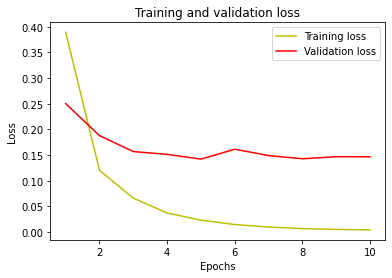

In [27]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

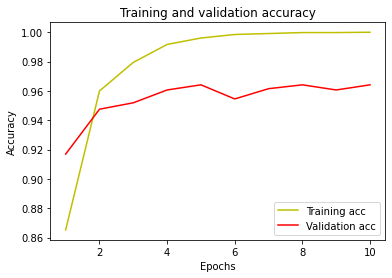

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 908ms/step
The prediction for this image is:  0
The actual label for this image is:  0


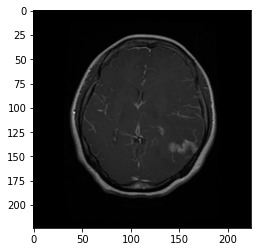

In [29]:
#Test on single image.
n=10  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, class)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))
print("The actual label for this image is: ", np.argmax(y_test[n]))

1/1 [==============================] - 0s 23ms/step
The prediction for this image is:  3


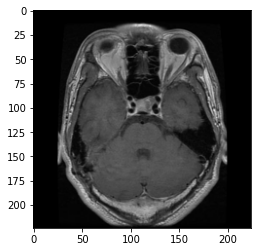

In [30]:
#Test on single image from other sources.
  
img = '/content/drive/MyDrive/Nickparver_156MB/Testing/pituitary/Te-piTr_0000.jpg'
image = cv2.imread(img)
image = Image.fromarray(image, 'RGB')
image = image.resize((SIZE, SIZE))
plt.imshow(image)
input_img = np.expand_dims(image, axis=0) #Expand dims so the input is (num images, x, y, class)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))

36/36 [==============================] - 10s 199ms/step


[Text(0, 0.5, 'glioma'),
 Text(0, 1.5, 'meningioma'),
 Text(0, 2.5, 'no_tumor'),
 Text(0, 3.5, 'pituitary')]

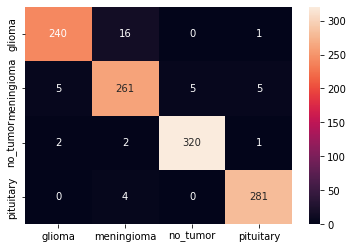

In [31]:
#Print confusion matrix on Validation Set
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
cm=confusion_matrix(np.argmax(y_test, axis=1), y_pred)  
ax = sns.heatmap(cm, annot=True, fmt = 'd')
ax.xaxis.set_ticklabels(['glioma', 'meningioma','no_tumor', 'pituitary'])
ax.yaxis.set_ticklabels(['glioma', 'meningioma','no_tumor', 'pituitary']) 

In [32]:
#Classifiction Report of Validation Set
classification_report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=['glioma', 'meningioma','no_tumor', 'pituitary'])
print(classification_report)

              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       257
  meningioma       0.92      0.95      0.93       276
    no_tumor       0.98      0.98      0.98       325
   pituitary       0.98      0.99      0.98       285

    accuracy                           0.96      1143
   macro avg       0.96      0.96      0.96      1143
weighted avg       0.96      0.96      0.96      1143



In [33]:
#Test set Results

In [34]:
new_data_directory = '/content/drive/MyDrive/Nickparver_156MB/Testing/'

SIZE = 224
new_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
new_label = [] 

In [35]:
glioma_images = os.listdir(new_data_directory + 'glioma/')
for i, image_name in enumerate(glioma_images):    
    
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(new_data_directory + 'glioma/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        new_dataset.append(np.array(image))
        new_label.append(0)



meningioma_images = os.listdir(new_data_directory + 'meningioma/')
for i, image_name in enumerate(meningioma_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(new_data_directory + 'meningioma/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        new_dataset.append(np.array(image))
        new_label.append(1)

notumor_images = os.listdir(new_data_directory + 'notumor/')
for i, image_name in enumerate(notumor_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(new_data_directory + 'notumor/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        new_dataset.append(np.array(image))
        new_label.append(2)

pituitary_images = os.listdir(new_data_directory + 'pituitary/')
for i, image_name in enumerate(pituitary_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(new_data_directory + 'pituitary/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        image = nd.gaussian_filter(image, sigma=1)
        new_dataset.append(np.array(image))
        new_label.append(3)

In [36]:
new_dataset = np.array(new_dataset)
new_label = np.array(new_label)

In [37]:
from sklearn.model_selection import train_test_split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(new_dataset, new_label, test_size = 0.999, random_state = 0)

In [38]:
from tensorflow.keras.utils import to_categorical
y_train_new = to_categorical(y_train_new)
y_test_new = to_categorical(y_test_new)

In [39]:
_, acc = model.evaluate(X_test_new, y_test_new)
print("Accuracy = ", (acc * 100.0), "%")

41/41 [==============================] - 9s 208ms/step - loss: 0.1246 - accuracy: 0.9664
Accuracy =  96.64121866226196 %


41/41 [==============================] - 6s 140ms/step


[Text(0, 0.5, 'glioma'),
 Text(0, 1.5, 'meningioma'),
 Text(0, 2.5, 'no_tumor'),
 Text(0, 3.5, 'pituitary')]

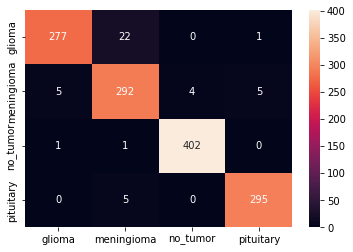

In [40]:
#Print confusion matrix for Test Set
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_pred_new = np.argmax(model.predict(X_test_new), axis=1)
cm=confusion_matrix(np.argmax(y_test_new, axis=1), y_pred_new)  
ax = sns.heatmap(cm, annot=True, fmt = 'd')
ax.xaxis.set_ticklabels(['glioma', 'meningioma','no_tumor', 'pituitary'])
ax.yaxis.set_ticklabels(['glioma', 'meningioma','no_tumor', 'pituitary']) 

In [41]:
#Classifiction Report for Test Set
classification_report = classification_report(np.argmax(y_test_new, axis=1), y_pred_new, target_names=['glioma', 'meningioma','no_tumor', 'pituitary'])
print(classification_report)

              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.91      0.95      0.93       306
    no_tumor       0.99      1.00      0.99       404
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.97      1310
   macro avg       0.97      0.96      0.96      1310
weighted avg       0.97      0.97      0.97      1310




**Annotate tumor type with Bounding Box**

In [42]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from skimage.measure import label, regionprops, find_contours

In [43]:
""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [44]:
""" Convert a mask to border image """
def mask_to_border(mask):
    h, w = mask.shape
    border = np.zeros((h, w))

    contours = find_contours(mask, 128)
    for contour in contours:
        for c in contour:
            x = int(c[0])
            y = int(c[1])
            border[x][y] = 255

    return border

In [45]:
""" Mask to bounding boxes """
def mask_to_bbox(mask):
    bboxes = []

    mask = mask_to_border(mask)
    lbl = label(mask)
    props = regionprops(lbl)
    for prop in props:
        x1 = prop.bbox[1]
        y1 = prop.bbox[0]

        x2 = prop.bbox[3]
        y2 = prop.bbox[2]

        bboxes.append([x1, y1, x2, y2])

    return bboxes

In [46]:
def parse_mask(mask):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)
    return mask

**Segmentation, Classification and Annotation of MRI**

1/1 [==============================] - 0s 79ms/step
The prediction for this image is:  0


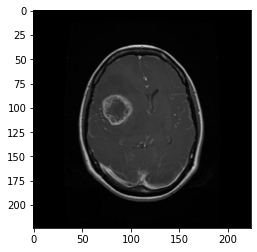

In [47]:
from matplotlib import colors
import matplotlib.pyplot as plt

#first take the required MRI and predict the tumor class
test_mri_path = "/content/drive/MyDrive/Nickparver_156MB/Testing/glioma/Te-gl_0014.jpg"
img = test_mri_path
image = cv2.imread(img)
image = Image.fromarray(image, 'RGB')
image = image.resize((SIZE, SIZE))
plt.imshow(image)
input_img = np.expand_dims(image, axis=0) #Expand dims so the input is (num images, x, y, class)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))



In [ ]:
#then show the tumor type

In [48]:
prediction = np.argmax(model.predict(input_img))
#print(prediction)
if prediction==0:
  tumor = 'Glioma'
elif prediction==1:
  tumor = 'Meningioma'
elif prediction==2:
  tumor = 'No Tumor'
else:
  tumor = 'pituitary'


print(tumor)

1/1 [==============================] - 0s 21ms/step
Glioma


In [ ]:
#Now Segment the tumor part

In [49]:
img = cv2.imread(img, cv2.IMREAD_COLOR)
img = cv2.resize(img, (W, H))
x = img/255.0
x = x.astype(np.float32)
x = np.expand_dims(x, axis=0)


y_pred = u_model.predict(x)[0] > 0.7
y_pred = y_pred.astype(np.int32)
y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

sep_line = np.ones((H, 10, 3)) * 255
output_img = np.concatenate([img,sep_line,y_pred*255], axis=1)
cv2.imwrite("seg_result.png", output_img)
cv2.imwrite("seg_tumor_mask.png", y_pred*255)#Save this for further use

1/1 [==============================] - 0s 25ms/step


True

In [ ]:
#Create the bounding box 

In [50]:
images = test_mri_path
img = cv2.imread(images, cv2.IMREAD_COLOR)
img = cv2.resize(img, (256, 256))
#cv2.imwrite("new.jpg",img)

In [51]:
mask1 = "/content/seg_tumor_mask.png"
mask_1 = cv2.imread(mask1, cv2.IMREAD_GRAYSCALE)
mask_1 = cv2.resize(mask_1, (256,256))#make sure mri and mask sizes are identical

In [52]:

        #""" Detecting bounding boxes """
bboxes = mask_to_bbox(mask_1)

        #""" marking bounding box on image """
for bbox in bboxes:
      img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

        #""" Saving the image """
cat_image = np.concatenate([img, parse_mask(mask_1)], axis=1)
Tumor = tumor #taken from prediction
cv2.putText(cat_image,Tumor, (bbox[0], bbox[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255))
cv2.imwrite(f"output.png", cat_image)

True